# SNN de los ganglios basales

Red de impulsos de los ganglios basales usando la implementación del modelo de Otsuka para neuronas del STN. El resto de parámetros de la simulación se extraen de Shouno et al.


### Referencias

Otsuka, T., Abe, T., Tsukagawa, T., & Song, W. J. (2004). Conductance-based model of the voltage-dependent generation of a plateau potential in subthalamic neurons. Journal of neurophysiology, 92(1), 255-264.

Shouno, O., Tachibana, Y., Nambu, A., & Doya, K. (2017). Computational model of recurrent subthalamo-pallidal circuit for generation of parkinsonian oscillations. Frontiers in Neuroanatomy, 11, 21.

In [1]:
# nest 
import nest
import nest.voltage_trace
from pynestml.frontend.pynestml_frontend import generate_nest_target

# gráficas
import matplotlib.pyplot as plt

# cálculo
from scipy import stats as st
from scipy import signal
from random import randint
import numpy as np

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func('statusdict/prefix ::')

nest.set_verbosity('M_WARNING')
nest.ResetKernel()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: UNKNOWN
 Built: Apr 14 2022 16:45:38

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Modelo de Otsuka para el STN

In [2]:
otsuka = """
neuron otsuka_stn:

  state:
        
    just_after_spike integer = 0
    
    # membrane potential
    V_m mV = V_L
    
    # activation/inactivation variables
    a  real = 0.0            
    b  real = 0.0
    c  real = 0.0
    d1 real = 0.0
    d2 real = 0.0
    h  real = 0.0
    m  real = 0.0
    n  real = 0.0
    p  real = 0.0
    q  real = 0.0
    r  real = 0.0
    
    # Ca concentration
    Ca_C real = 0.0
    
    # receptors 
    g_ampa_a1  real = 0.0
    g_ampa_a2  real = 0.0
    g_gabaa_a2 real = 0.0
    g_gabaa_a1 real = 0.0
    g_gabab_a2 real = 0.0
    g_gabab_a1 real = 0.0
    
    # DA modulation
    da2_k_1_              real =  90.0
    da2_k_2_              real =   0.0036
    da2_k_3_              real =   0.18
    da2_k_4_              real =   0.034
    da2_k_d_              real = 100.0
    da2_g_max_            real =   1.0
    da2_T_                real =   1e-3
    da2_pulse_            real =   1.105
    da2_n_                real =   4.0
    da2_suppress_f        real =   1.0
    da2_suppress_f_const  real =   0.85
    da2_suppress_f_th     real =   0.5
    da2_g_out             real =   0.0
    da2_r_                real =   0.0
    da2_s_                real =   0.0
    
  end

  equations:
        
    # ionic currents
    recordable inline I_L     pA = g_L * (V_m - V_L)
    recordable inline I_K     pA = g_K * (n ** 4) * (V_m - V_K)
    recordable inline I_Na    pA = g_Na * (m ** 3) * h * (V_m - V_Na)
    recordable inline I_A     pA = g_Ia * (a ** 2) * (V_m - V_K)
    recordable inline I_LCa   pA = g_LCa * (c ** 2) * d1 * d2 * (V_m - V_Ca)
    recordable inline I_T     pA = g_T * (p ** 2) * q * (V_m - V_Ca)
    recordable inline I_CaK   pA = g_CaK * (r ** 4) * (V_m - V_K)             # r^4 (shouno), r^2 (otsuka)
    
    # receptor currents
    recordable inline I_AMPA  pA = convolve(g_ampa_a2,  AMPA)    * (V_m - V_E)    
    recordable inline I_GABAA pA = convolve(g_gabaa_a2, GABA_A) * (V_m - V_gabaa)
    recordable inline I_GABAB pA = convolve(g_gabab_a2, GABA_B) * (V_m - V_gabaa)
    
    n'  = (n_inf  -  n) / (tau_n0 + tau_n1 / ( exp(-(V_m-theta_tau_n0)/sigma_tau_n0) + exp(-(V_m-theta_tau_n1)/sigma_tau_n1) ))
    m'  = (m_inf  -  m) / (tau_m0 + tau_m1 / ( 1.0 + exp(-(V_m-theta_tau_m)/sigma_tau_m) ))
    h'  = (h_inf  -  h) / (tau_h0 + tau_h1 / ( exp(-(V_m-theta_tau_h0)/sigma_tau_h0) + exp(-(V_m-theta_tau_h1)/sigma_tau_h1) ))
    a'  = (a_inf  -  a) / (tau_a0 + tau_a1 / ( 1.0 + exp(-(V_m-theta_tau_a)/sigma_tau_a) ))
    b'  = (b_inf  -  b) / (tau_b0 + tau_b1 / ( exp(-(V_m-theta_tau_b0)/sigma_tau_b0) + exp(-(V_m-theta_tau_b1)/sigma_tau_b1) ))
    c'  = (c_inf  -  c) / (tau_c0 + tau_c1 / ( exp(-(V_m-theta_tau_c0)/sigma_tau_c0) + exp(-(V_m-theta_tau_c1)/sigma_tau_c1) ))
    d1' = (d1_inf - d1) / (tau_d0 + tau_d1 / ( exp(-(V_m-theta_tau_d0)/sigma_tau_d0) + exp(-(V_m-theta_tau_d1)/sigma_tau_d1) ))
    d2' = (d2_inf - d2) / divisor_d2
    p'  = (p_inf  -  p) / (tau_p0 + tau_p1 / ( exp(-(V_m-theta_tau_p0)/sigma_tau_p0) + exp(-(V_m-theta_tau_p1)/sigma_tau_p1) ))
    q'  = (q_inf  -  q) / (tau_q0 + tau_q1 / ( exp(-(V_m-theta_tau_q0)/sigma_tau_q0) + exp(-(V_m-theta_tau_q1)/sigma_tau_q1) ))
    r'  = (r_inf  -  r) / divisor_r
    
    # kernel function for each receptor 
    kernel g_ampa_a2'  =  g_ampa_a1 - g_ampa_a2 / tau_syn_ampa
           g_ampa_a1'  = -g_ampa_a1 / tau_syn_ampa
   
    kernel g_gabaa_a2' =  g_gabaa_a1 * (1.0/tau_syn_gabaa2 - 1.0/tau_syn_gabaa1) - g_gabaa_a2/tau_syn_gabaa1
           g_gabaa_a1' = -g_gabaa_a1 / tau_syn_gabaa2
    
    kernel g_gabab_a2' =  g_gabab_a1 - g_gabab_a2/tau_syn_gabab
           g_gabab_a1' = -g_gabab_a1 / tau_syn_gabab 
    

    # membrane potential (shouno)
    V_m' = (- I_L - I_K - I_Na - I_A - I_T - I_LCa - I_CaK - (I_AMPA/area) - (I_GABAA/area) - (I_GABAB/area) + (I0/area) + (I_stim/area)) / C_m   
        
  end

  parameters:
    
    # prevents unit errors during odes integration
    divisor_d2 ms    = 130 ms     
    divisor_r  ms    = 2 ms
    divisor_r_inf mV = -0.08 mV
    
    V_th mV  = -30.0 mV        # threshold (shouno)
    C_m pF   =   100 pF        # membrane capacitance 
        
    V_L mV   = -60.0 mV        # leak-current reversal potential
    V_K mV   = -90.0 mV        # potassium current reversal potential (K+) 
    V_Na mV  =  60.0 mV        # sodium current reversal potential (Na+)
    V_Ca mV  = 140.0 mV        # calcium current reversal potential (Ca++) (source: shouno)
    
    # maximal conductances 
    g_L mS   =  0.35 mS        # leak conductance
    g_K mS   = 57.0  mS        # postassium conductance
    g_Na mS  = 49.0  mS        # sodium conductance          
    g_Ia mS  =  5.0  mS        # A-current conductance
    g_LCa mS = 15.0  mS        # L-type calcium conductance
    g_T mS   =  5.0  mS        # T-current conductance
    g_CaK mS =  1.0  mS        # AHP-current conductance
    
    # time constants of activation/inactivation
    tau_n0 ms =   0.0  ms 
    tau_n1 ms =  11.0  ms
    tau_m0 ms =   0.2  ms
    tau_m1 ms =   3.0  ms
    tau_h0 ms =   0.0  ms
    tau_h1 ms =  24.5  ms
    tau_b0 ms =   0.0  ms
    tau_b1 ms = 200.0  ms
    tau_c0 ms =  45.0  ms
    tau_c1 ms =  10.0  ms
    tau_d0 ms = 400.0  ms
    tau_d1 ms = 500.0  ms
    tau_p0 ms =   5.0  ms
    tau_p1 ms =   0.33 ms
    tau_q0 ms =  10.0  ms # otsuka: 0    shouno:10
    tau_q1 ms = 400.0  ms # otsuka: 400  shouno: 1600
    tau_a0 ms =   1.0  ms
    tau_a1 ms =   1.0  ms
    
    # half activation voltages
    theta_n  mV = -41.0 mV
    theta_m  mV = -40.0 mV
    theta_h  mV = -45.5 mV
    theta_a  mV = -45.0 mV
    theta_b  mV = -90.0 mV
    theta_c  mV = -30.6 mV
    theta_d1 mV = -60.0 mV
    theta_p  mV = -56.0 mV
    theta_q  mV = -85.0 mV
    
    # slope factors
    sigma_n  mV = -14.0  mV
    sigma_m  mV =  -8.0  mV
    sigma_h  mV =   6.4  mV
    sigma_a  mV = -14.7  mV
    sigma_b  mV =   7.5  mV
    sigma_c  mV =  -5.0  mV
    sigma_d1 mV =   7.5  mV
    sigma_p  mV =  -6.7  mV
    sigma_q  mV =   5.8  mV
    sigma_d2 mV =   0.02 mV
    
    theta_tau_m  mV =  -53.0 mV
    theta_tau_a  mV =  -40.0 mV
    theta_tau_n0 mV =  -40.0 mV
    theta_tau_n1 mV =  -40.0 mV
    theta_tau_h0 mV =  -50.0 mV
    theta_tau_h1 mV =  -50.0 mV
    theta_tau_b0 mV =  -60.0 mV
    theta_tau_b1 mV =  -40.0 mV
    theta_tau_c0 mV =  -27.0 mV
    theta_tau_c1 mV =  -50.0 mV
    theta_tau_d0 mV =  -40.0 mV
    theta_tau_d1 mV =  -20.0 mV
    theta_tau_p0 mV =  -27.0 mV
    theta_tau_p1 mV = -102.0 mV
    theta_tau_q0 mV =  -50.0 mV
    theta_tau_q1 mV =  -50.0 mV
    
    # slope factor for the voltage dependence of time constants
    sigma_tau_m  mV =   -0.7 mV 
    sigma_tau_a  mV =   -0.5 mV
    sigma_tau_n0 mV =  -40.0 mV
    sigma_tau_n1 mV =   50.0 mV
    sigma_tau_h0 mV =  -15.0 mV
    sigma_tau_h1 mV =   16.0 mV
    sigma_tau_b0 mV =  -30.0 mV
    sigma_tau_b1 mV =   10.0 mV
    sigma_tau_c0 mV =  -20.0 mV
    sigma_tau_c1 mV =   15.0 mV
    sigma_tau_d0 mV =  -15.0 mV
    sigma_tau_d1 mV =   20.0 mV
    sigma_tau_p0 mV =  -10.0 mV
    sigma_tau_p1 mV =   15.0 mV
    sigma_tau_q0 mV =  -15.0 mV
    sigma_tau_q1 mV =   16.0 mV
    
    k1_r    real = 0.17       # dissociation constant of calcium-dependent AHP current
    k1_d2   real = 0.1        # dissociation constant of calcium-dependent AHP current
    k_Ca    real = 2.0        # calcium pump rate constant
        
    # time constants for excitatory (ampa) and inhibitory (gaba) synapses
    tau_syn_ampa        ms =   1.0 ms
    tau_syn_gabaa_rise  ms =   0.4 ms
    tau_syn_gabaa_decay ms =   7.7 ms
    tau_syn_gabab       ms = 175.2 ms
    tau_syn_gabaa1      ms = tau_syn_gabaa_decay
    tau_syn_gabaa2      ms = tau_syn_gabaa1 * tau_syn_gabaa_rise /(tau_syn_gabaa1 + tau_syn_gabaa_rise)
    
    # synapse conductances 
    ampa_conductance  nS = 0.0 nS
    gabaa_conductance nS = 0.0 nS
    gabab_conductance nS = 0.0 nS
    
    # reversal potential for excitatory and inhibitory synapses
    V_E     mV =   0.0 mV
    V_gabaa mV = -78.9 mV
    V_gabab mV = -93.3 mV
    
    # persistent DC input current
    I0 pA = 0.0 pA
    
    # refractory period
    t_ref ms = 2 ms  
    
    # scale parameter 
    area real = 0.1 
    
    # DA modulation (0.0: no modulation, 1.0: modulation)
    da2_Ca_modulation real = 0.0      
        
    output_all_variable_data boolean = false
    output_condunctance_data boolean = false
    inactivate_GABAA_synapse boolean = false
    
    # activation/inactivation variables infinity 
    n_inf  real = 1.0/( 1.0+exp((V_m-theta_n)/sigma_n))       # n:  I_K activation variable
    m_inf  real = 1.0/( 1.0+exp((V_m-theta_m)/sigma_m))       # m:  I_Na activation variable
    h_inf  real = 1.0/( 1.0+exp((V_m-theta_h)/sigma_h))       # h:  I_Na inactivation variable
    a_inf  real = 1.0/( 1.0+exp((V_m-theta_a)/sigma_a))       # a:  I_A activation variable
    b_inf  real = 1.0/( 1.0+exp((V_m-theta_b)/sigma_b))       # b:  I_A inactivation variable
    c_inf  real = 1.0/( 1.0+exp((V_m-theta_c)/sigma_c))       # c:  I_LCa activation variable
    d1_inf real = 1.0/( 1.0+exp((V_m-theta_d1)/sigma_d1))     # d1: I_LCa inactivation variable
    d2_inf real = 1.0/( 1.0+exp((Ca_C - k1_d2)/sigma_d2))     # d2: I_LCa inactivation variable
    p_inf  real = 1.0/( 1.0+exp((V_m-theta_p)/sigma_p))       # p:  I_T activation variable
    q_inf  real = 1.0/( 1.0+exp((V_m-theta_q)/sigma_q))       # q:  I_T inactivation variable
    r_inf  real = 1.0/( 1.0+exp((Ca_C - k1_r)/divisor_r_inf)) # r:  I_CaK activation variable
     
  end

  internals:
    delta_ampa  real = e / tau_syn_ampa 
    delta_gabaa real = 1.0 / ( ((tau_syn_gabaa2/tau_syn_gabaa1)**(tau_syn_gabaa_rise/tau_syn_gabaa1)) - ((tau_syn_gabaa2/tau_syn_gabaa1)**(tau_syn_gabaa_rise/tau_syn_gabaa2)) )
    delta_gabab real = e / tau_syn_gabab
    
    RefractoryCounts integer = steps(t_ref) 
  end

  input:
    AMPA nS      <- excitatory spike
    GABA_A nS    <- inhibitory spike
    GABA_B nS    <- inhibitory spike
    DA_spikes nS <- spike
    I_stim pA    <- continuous
  end

  output: spike

  update:
                
    U_old mV = V_m
    
    # solve differential equations
    integrate_odes()
        
    # da modulation
    if da2_Ca_modulation == 0.0:
        if da2_g_out >= da2_suppress_f_th:
            da2_suppress_f = da2_suppress_f_const
        end
    end
        
    # check membrane potential and fire
    if V_m < V_th:
        just_after_spike = 0
    elif V_m >= V_th and just_after_spike == 0:      
        just_after_spike = 1
        emit_spike()   
    end
      
  end
end
"""

In [3]:
with open('otsuka_stn.nestml', 'w') as nestml_model_file:
    print(otsuka, file=nestml_model_file)

generate_nest_target(input_path='otsuka_stn.nestml',
                     target_path='/tmp/otsuka_stn',
                     module_name='otsuka_stn_module',
                     logging_level='ERROR', 
                     codegen_opts={'nest_path': NEST_SIMULATOR_INSTALL_LOCATION})



-- The CXX compiler identification is GNU 9.4.0
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
otsuka_stn_module Configuration Summary
-------------------------------------------------------

C++ compiler         : /usr/bin/c++
Build static libs    : OFF
C++ compiler flags   : 
NEST compiler flags  :  -O2 -std=c++11 -Wall -fopenmp -pthread -fdiagnostics-color=auto
NEST include dirs    :  -I/opt/nest/include/nest -I/usr/include -I/usr/include -I/usr/include -I/opt/music-install/include -I/usr/lib/x86_64-linux-gnu/openmpi/include/openmpi -I/usr/lib/x86_64-linux-gnu/openmpi/include -I/usr/include
NEST libraries flags : -L/opt/nest/lib/nest -lnestutil -lnest -lsli -lnestkernel -fopenmp /usr/lib/x86_64-linux-gnu/libltdl.so /us

In [4]:
nest.Install('otsuka_stn_module')

## Parámetros simulación

In [5]:
# tiempo de la simulación
simtime = 2000.0

## Parámetros STN

In [6]:
# numero de neuronas stn
n_stn = 64

# probabilidad de conexión hacia el gpe (6/64)
n_conn_stn_to_gpe = 6

# pesos sinápticos stn
weight_stn = 1.05

# axonal conduction delay (presente en stn->gpe y gpe->stn)
axonal_cond_delay = 5

## Parámetros GPe

In [7]:
# numero de neuronas gpe
n_gpe = 192

# probabilidad de conexion hacia el gpe (12/192)
n_conn_gpe_to_stn = 12

# pesos sinápticos gpe
weight_gpe = 3.65

## Parámetros GPe-Int (Poisson)

In [8]:
# numero neuronas
n_gpe_int = 192

# tasa de disparo gpe (Hz)
rate_gpe_int = 30.0

# pesos sinápticos poisson
weight_gpe_int = 1.125

## Parámetros Cortex (Poisson)

In [9]:
# numero de neuronas cortex
n_ctx = 64

# tasa de disparo cortex (Hz)
rate_ctx = 30.0  

# pesos sinápticos cortex
weight_ctx = 1.0

## Poblaciones

In [10]:
# núcleos
stn = nest.Create('otsuka_stn', n_stn)
gpe = nest.Create('iaf_cond_beta', n_gpe)

# gpe internal noisy conductance
gpe_int = nest.Create('poisson_generator', n_gpe_int, params={'rate': rate_gpe_int})

# cortex
ctx = nest.Create('poisson_generator', n_ctx, params={'rate': rate_ctx})

# recorders stn y gpe
spike_recorder_stn = nest.Create('spike_recorder')
spike_recorder_gpe = nest.Create('spike_recorder')
spike_recorder_gpe_int = nest.Create('spike_recorder')
spike_recorder_ctx = nest.Create('spike_recorder')

### Conexiones

In [11]:
# stn --> gpe
nest.Connect(
    stn, gpe, {'rule': 'fixed_total_number', 'N': n_conn_stn_to_gpe},
    syn_spec={'synapse_model': 'quantal_stp_synapse', 'weight': weight_stn, 'delay': axonal_cond_delay}
)

# gpe --> stn
nest.Connect(
    gpe, stn, {'rule': 'fixed_total_number', 'N': n_conn_gpe_to_stn},
    syn_spec={'synapse_model': 'quantal_stp_synapse', 'weight': weight_gpe, 'delay': axonal_cond_delay}
)

# gpe_int --> gpe
nest.Connect(
    gpe_int, gpe, {'rule': 'one_to_one'},
    syn_spec={'weight': weight_gpe_int}
)

# cortex --> stn
nest.Connect(
    ctx, stn, {'rule': 'pairwise_bernoulli', 'p': 0.03},
    syn_spec={'weight': weight_ctx}
)

# spike recorders
nest.Connect(stn, spike_recorder_stn)
nest.Connect(gpe, spike_recorder_gpe)
nest.Connect(gpe_int, spike_recorder_gpe_int)
nest.Connect(ctx, spike_recorder_ctx)

In [12]:
# multímetros al stn
multimeter_stn = []

for i in range(64):
    multimeter = nest.Create('multimeter')
    multimeter.interval = 0.1
    multimeter.set(record_from=['V_m'])
    nest.Connect(multimeter, stn[i])
    multimeter_stn.append(multimeter)
    
    
# multímetro al gpe
multimeter_gpe = []

for i in range(64):
    multimeter = nest.Create('multimeter')
    multimeter.interval = 0.1
    multimeter.set(record_from=['V_m'])
    nest.Connect(multimeter, gpe[i])
    multimeter_gpe.append(multimeter)

## Simulación

In [13]:
nest.Simulate(simtime)

### Voltajes de neurona

#### STN

(85, 180)

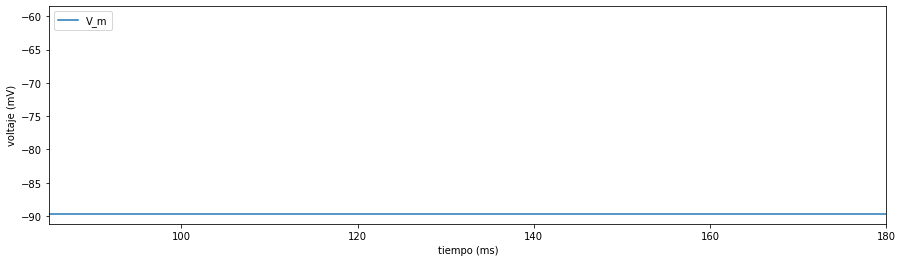

In [14]:
dmm = multimeter_stn[0].get()

plt.rcParams['figure.figsize'] = (15,4)

ts = dmm['events']['times']
Vms = dmm['events']['V_m']

ax0 = plt.subplot()
ax0.plot(ts, Vms, label='V_m', color='C0')
ax0.legend(loc='upper left')

ax0.set_xlabel('tiempo (ms)')
ax0.set_ylabel('voltaje (mV)')

plt.xlim((85,180))

#### GPe

Text(0, 0.5, 'voltaje (mV)')

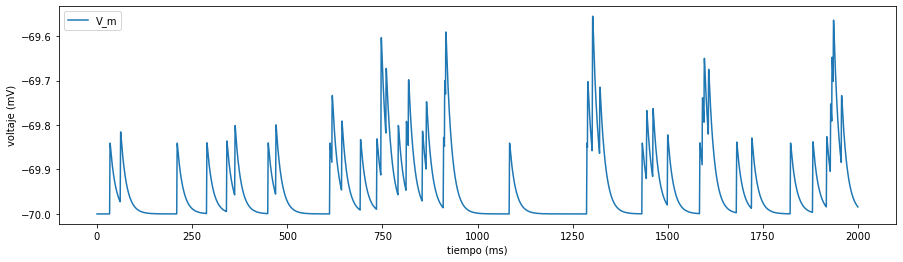

In [15]:
dmm = multimeter_gpe[0].get()

plt.rcParams['figure.figsize'] = (15,4)

ts = dmm['events']['times']
Vms = dmm['events']['V_m']

ax0 = plt.subplot()
ax0.plot(ts, Vms, label='V_m', color='C0')
ax0.legend(loc='upper left')

ax0.set_xlabel('tiempo (ms)')
ax0.set_ylabel('voltaje (mV)')

### Registro de disparos por población

In [16]:
try:
    nest.raster_plot.from_device(spike_recorder_stn, hist=True)
    plt.title('stn')
    plt.show()
except:
    print('No events recorded!')

No events recorded!


In [17]:
try:
    nest.raster_plot.from_device(spike_recorder_gpe, hist=True)
    plt.title('gpe')
    plt.show()
except:
    print('No events recorded!')

No events recorded!


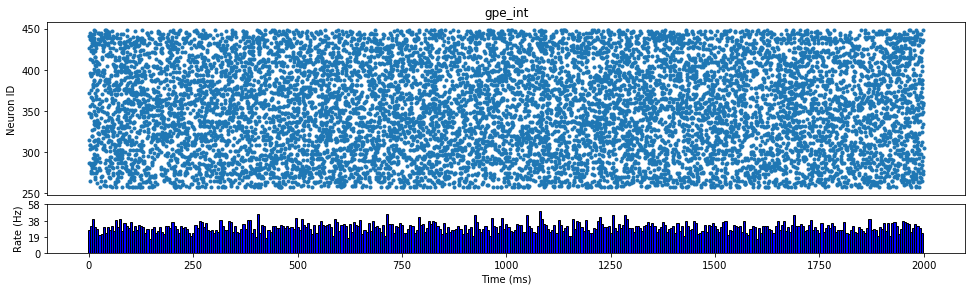

In [18]:
nest.raster_plot.from_device(spike_recorder_gpe_int, hist=True)
plt.title('gpe_int')
plt.show()

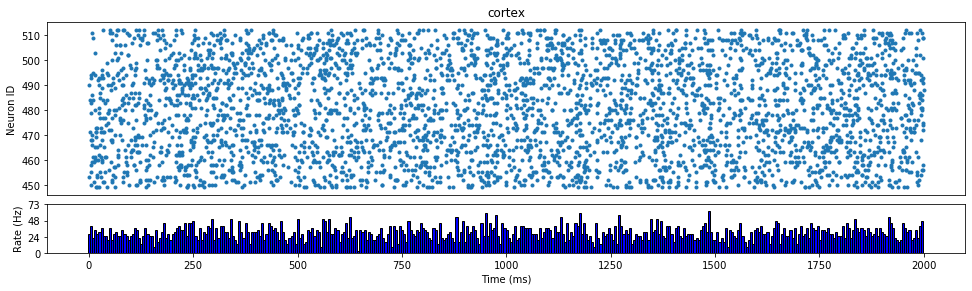

In [19]:
nest.raster_plot.from_device(spike_recorder_ctx, hist=True)
plt.title('cortex')
plt.show()

### Conexiones en la red

In [20]:
conn = nest.GetConnections()
nest.PrintNodes()

  1 ..  64 otsuka_stn
 65 .. 256 iaf_cond_beta
257 .. 512 poisson_generator
513 .. 516 spike_recorder
517 .. 644 multimeter


# Métricas de análisis

## Power spectral density

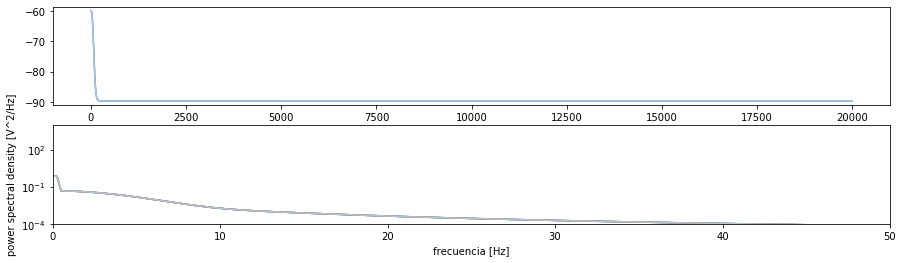

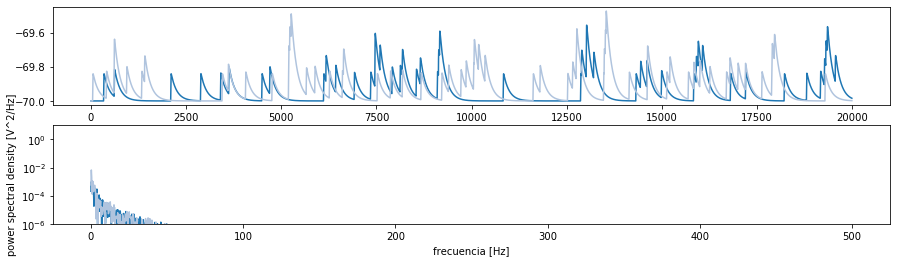

In [21]:
stn_data, gpe_data = ([] for i in range(2))

for i in range(64):
    stn_data.append(multimeter_stn[i].events['V_m'])
    gpe_data.append(multimeter_gpe[i].events['V_m'])
    
# stn
plt.subplot(211)

plt.plot(stn_data[0])
plt.plot(stn_data[1], color='lightsteelblue')

conf_level_data_stn = dict()

plt.subplot(212)

for i in range(2):
    f, Pxx_den = signal.periodogram(x=stn_data[i], fs=1000, window=('hamming'), nfft=4096)
    plt.semilogy(f, Pxx_den)
    data_log = plt.semilogy(f, Pxx_den, color=('C0' if i==0 else 'lightsteelblue'))
    conf_level_data_stn[i] = dict()
    conf_level_data_stn[i]['y'] = data_log[0].get_ydata()
    conf_level_data_stn[i]['x'] = data_log[0].get_xdata()

plt.xlabel('frecuencia [Hz]')
plt.ylabel('power spectral density [V^2/Hz]')
    
plt.ylim((10e-5,10e3))
plt.xlim((0,50))
plt.show()

# gpe
plt.subplot(211)

plt.plot(gpe_data[0], color='C0')
plt.plot(gpe_data[1], color='lightsteelblue')

conf_level_data_gpe = dict()

plt.subplot(212)
for i in range(2):
    f, Pxx_den = signal.periodogram(x=gpe_data[i], fs=1000, window=('hamming'), nfft=4096)
    data_log = plt.semilogy(f, Pxx_den, color=('C0' if i==0 else 'lightsteelblue'))
    conf_level_data_gpe[i] = dict()
    conf_level_data_gpe[i]['y'] = data_log[0].get_ydata()
    conf_level_data_gpe[i]['x'] = data_log[0].get_xdata()

plt.xlabel('frecuencia [Hz]')
plt.ylabel('power spectral density [V^2/Hz]')
    
plt.ylim((10e-7,10))
#plt.xlim((0, 50)) 
plt.show()

### Intervalos de confianza STN

In [22]:
# número de puntos eje X
num_datos = len(conf_level_data_stn[0]['x'])

# mínimo y máximo para los intervalos de confianza (se calculan entre 270 y 300 Hz)
for i in range(num_datos):
    if conf_level_data_stn[0]['x'][i] >=270:
        indice_min = i
        break
        
for i in range(num_datos):
    if conf_level_data_stn[0]['x'][i] >= 300:
        indice_max = i + 1
        break
        
# recortar datos acorde a ese intervalo
for i in range(2):
    conf_level_data_stn[i]['x'] = conf_level_data_stn[i]['x'][indice_min:indice_max]
    conf_level_data_stn[i]['y'] = conf_level_data_stn[i]['y'][indice_min:indice_max]

(2.5220283372793734e-06, 3.1711177474151483e-06)
(2.5220283372793734e-06, 3.1711177474151483e-06)


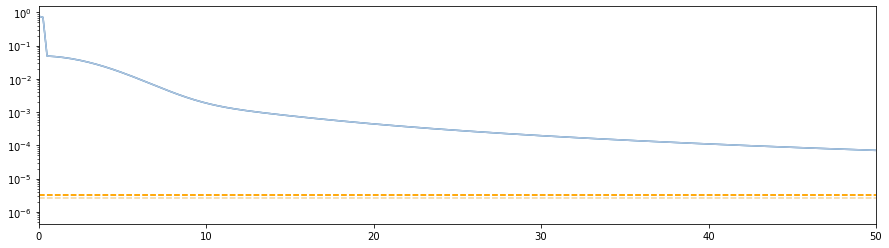

In [23]:
# intervalos de confianza al 99%

conf_interval_stn = []

for i in range(2):
    conf_interval_stn.append(st.norm.interval(alpha=0.99, loc=st.tmean(conf_level_data_stn[i]['y']), scale=st.tstd(conf_level_data_stn[i]['y'])))
    
for i in range(2):
    f, Pxx_den = signal.periodogram(x=stn_data[i], fs=1000, window=('hamming'), nfft=4096)
    data_log = plt.semilogy(f, Pxx_den, color=('C0' if i==0 else 'lightsteelblue'))
    plt.axhline(y=conf_interval_stn[i][0], color='wheat', linestyle='--')
    plt.axhline(y=conf_interval_stn[i][1], color='orange', linestyle='--')
    
plt.xlim(0,50)

print(conf_interval_stn[0])
print(conf_interval_stn[1])   

### Intervalos de confianza GPe

In [24]:
# número de puntos eje X
num_datos = len(conf_level_data_gpe[0]['x'])

# mínimo y máximo para los intervalos de confianza (se calculan entre 270 y 300 Hz)
for i in range(num_datos):
    if conf_level_data_gpe[0]['x'][i] >= 270:
        indice_min = i
        break
        
for i in range(num_datos):
    if conf_level_data_gpe[0]['x'][i] >= 300:
        indice_max = i + 1
        break
        
# recortar datos acorde a ese intervalo
for i in range(2):
    conf_level_data_gpe[i]['x'] = conf_level_data_gpe[i]['x'][indice_min:indice_max]
    conf_level_data_gpe[i]['y'] = conf_level_data_gpe[i]['y'][indice_min:indice_max]

(-9.569822027395635e-11, 2.814694038106926e-10)
(-1.9799338337319988e-10, 5.248409144158076e-10)


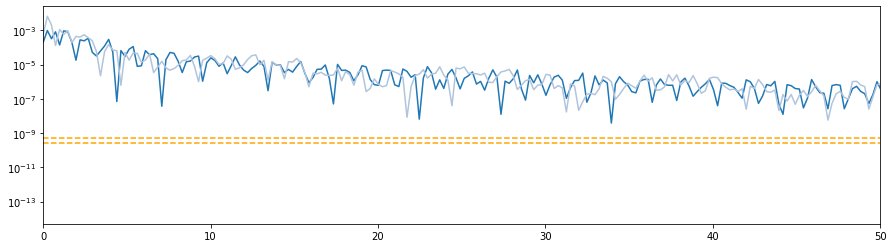

In [25]:
# intervalos de confianza al 99%

conf_interval = []

for i in range(2):
    conf_interval.append(st.norm.interval(alpha=0.99, loc=st.tmean(conf_level_data_gpe[i]['y']), scale=st.tstd(conf_level_data_gpe[i]['y'])))
    
for i in range(2):
    f, Pxx_den = signal.periodogram(x=gpe_data[i], fs=1000, window=('hamming'), nfft=4096)
    data_log = plt.semilogy(f, Pxx_den, color=('C0' if i==0 else 'lightsteelblue'))
    plt.axhline(y=conf_interval[i][0], color='wheat', linestyle='--')
    plt.axhline(y=conf_interval[i][1], color='orange', linestyle='--')
    
plt.xlim(0,50)

print(conf_interval[0])
print(conf_interval[1])    

## Cross spectral analysis

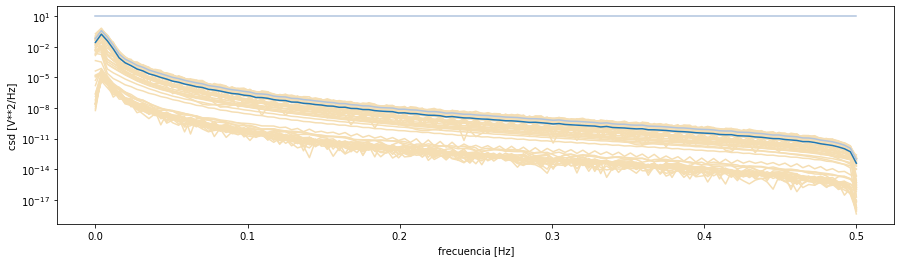

In [26]:
signals = []

#  csd de cada par de neuronas stn-gpe
for i in range(64):
    f, Pxy = signal.csd(x=stn_data[i], y=gpe_data[i], window='hann')
    line = plt.semilogy(f, np.abs(Pxy), color=('wheat' if (i%2)==0 else 'wheat'))
    signals.append(line[0].get_ydata())

# media de los csd anteriores  
# ---------------------------

fil = len(signals)
col = len(signals[0])
    
added_signals = [0] * col
    
for i in range(col):
    for j in range(fil):
        added_signals[i] = added_signals[i] + signals[j][i]

for i in range(col):
    added_signals[i] = added_signals[i] / fil 
    
# plotear la media         
plt.plot(f, added_signals, color='C0')
    
    
# sd de los csd anteriores
# ------------------------

signals_as_columns = np.array([np.array(signal) for signal in signals])
signals_as_columns = np.rot90(signals_as_columns, k=1, axes=(0, 1))
signals_as_columns = np.flip(signals_as_columns, 0)

signals_stds = []

for i in range(col):
    signals_stds.append( st.tstd(signals_as_columns[i]) )

# calcular límites std sobre la media
limite_stds_sup = []
limite_stds_inf = []

for i in range(col):
    if (added_signals[i] + signals_stds[i]) > 0:
        limite_stds_sup.append(added_signals[i] + signals_stds[i])
    else:
        limite_stds_sup.append(10)
    
    if (added_signals[i] - signals_stds[i]) > 0:
        limite_stds_inf.append(added_signals[i] - signals_stds[i])
    else:
        limite_stds_inf.append(10)

# plotear límite de la std 
linea_sup = plt.plot(f, limite_stds_sup, color='lightsteelblue')
linea_inf = plt.plot(f, limite_stds_inf, color='lightsteelblue')

plt.xlabel('frecuencia [Hz]')
plt.ylabel('csd [V**2/Hz]')

#plt.ylim(10e-6,10e2)

plt.show()

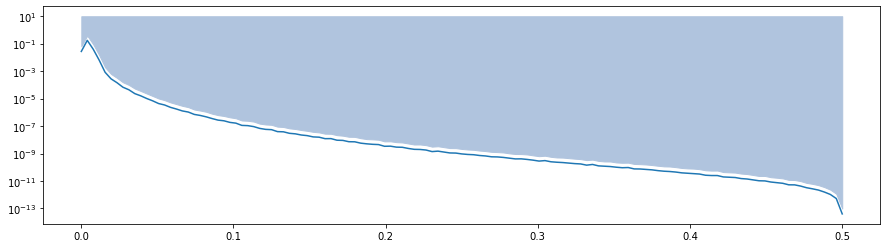

In [27]:
plt.semilogy(f, added_signals, color='C0')
plt.fill_between(x=f, y1=limite_stds_sup, y2=limite_stds_inf, color='lightsteelblue')